In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import time
import csv
from tensorflow.keras import layers, models

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam

2024-06-01 17:31:31.428528: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-01 17:31:31.428641: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-01 17:31:31.546980: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
image_dir = Path('/kaggle/input/dataset-de-comida-portuguesa-correto/Dataset de Comida Portuguesa/')

jpg_filepaths = list(image_dir.glob(r'**/*.jpg'))
jpeg_filepaths = list(image_dir.glob(r'**/*.jpeg'))
png_filepaths = list(image_dir.glob(r'**/*.png'))
gif_filepaths = list(image_dir.glob(r'**/*.gif'))

# Combine all filepaths into a single list
filepaths = jpg_filepaths + jpeg_filepaths + png_filepaths + gif_filepaths

print(f"Number of files found: {len(filepaths)}")

Number of files found: 13919


# Criar o DataFrame do ficheiro & Divisão do Treino-Teste

In [3]:
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split

images = pd.concat([filepaths, labels], axis=1)

category_samples = []
for category in images['Label'].unique():
    category_slice = images.query("Label == @category")
    
    test_data = category_slice.sample(n=min(20, len(category_slice)), random_state=1)
    
    category_samples.append(test_data)

df_test = pd.concat(category_samples, axis=0)
df_train = images.drop(df_test.index)

print(f"Número de amostras de treino: {len(df_train)}")
print(f"Número de amostras de teste: {len(df_test)}")

Número de amostras de treino: 11919
Número de amostras de teste: 2000


In [6]:
df_train['Label'].value_counts()

Label
bacalhau_a_bras         334
bola_de_berlim          240
ameijoas                175
waffles                 155
tronco_de_natal         153
                       ... 
maranhos                 92
mil_folhas               90
travesseiro_de_noiva     84
pampilhos                80
farturas                 80
Name: count, Length: 100, dtype: int64

In [7]:
df_test['Label'].value_counts()

Label
cabrito_assado         20
sardinhas_assadas      20
pao_de_lo              20
cogumelos_salteados    20
filetes_de_pesacada    20
                       ..
feijoada               20
bolo_de_arroz          20
chocos_de_setubal      20
canja                  20
cozido_a_portuguesa    20
Name: count, Length: 100, dtype: int64

In [8]:
from tensorflow.keras.preprocessing import image
import pandas as pd
from sklearn.model_selection import train_test_split

def split_data_by_label(dataframe, test_size, random_state=42):
    dfs_first_part = []
    dfs_second_part = []
    
    labels = dataframe['Label'].unique()
    
    for label in labels:
        label_df = dataframe[dataframe['Label'] == label]
        train_data, test_data = train_test_split(label_df, test_size=test_size, random_state=random_state)
        
        dfs_first_part.append(test_data)
        
        remaining_data = label_df.loc[~label_df.index.isin(test_data.index)]
        dfs_second_part.append(remaining_data)
    
    first_part_df = pd.concat(dfs_first_part, ignore_index=True)
    second_part_df = pd.concat(dfs_second_part, ignore_index=True)
    
    return first_part_df, second_part_df

df_val,df_train = split_data_by_label(df_train, test_size=0.2, random_state=42)

In [9]:
print(f"Número de amostras de treino: {len(df_train)}")
print(f"Número de amostras de validação: {len(df_val)}")

Número de amostras de treino: 9498
Número de amostras de validação: 2421


# Criação de Geradores

In [10]:
generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.densenet.preprocess_input,
)

train_images = generator.flow_from_dataframe(
    dataframe=df_train,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = generator.flow_from_dataframe(
    dataframe=df_val,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42
)

test_images = generator.flow_from_dataframe(
    dataframe=df_test,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 9493 validated image filenames belonging to 100 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 5 invalid image filename(s) in x_col="Filepath". These filename(s) will be ignored.
  warnings.warn(


Found 2420 validated image filenames belonging to 100 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="Filepath". These filename(s) will be ignored.
  warnings.warn(


Found 2000 validated image filenames belonging to 100 classes.


# Modelagem

In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import DenseNet169 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.regularizers import l2

base_model = DenseNet169(weights='imagenet', include_top=False, input_shape=(224, 224, 3));

for layer in base_model.layers:
    layer.trainable = False
    
x = base_model.output
x = GlobalAveragePooling2D()(x) 
x = Dropout(0.4)(x) 
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
predictions = Dense(100, activation='softmax')(x)

# Criar o modelo final
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers[-50:]:
    layer.trainable = True

51877672/51877672 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [12]:
epocas = 20

lr_schedule = ExponentialDecay(initial_learning_rate=0.001, decay_steps=10000, decay_rate=0.9)

model.compile(optimizer=Adam(learning_rate=lr_schedule), loss='categorical_crossentropy', metrics=['accuracy'])

start = time.time()

history = model.fit(
    train_images,
    epochs= epocas,
    validation_data=val_images,
)

end = time.time()

print("\nThe time of training was :", (end-start), "seconds")

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/297 ━━━━━━━━━━━━━━━━━━━━ 5:15:35 64s/step - accuracy: 0.0000e+00 - loss: 5.8058

I0000 00:00:1717263185.480317      67 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 14/297 ━━━━━━━━━━━━━━━━━━━━ 1:57 415ms/step - accuracy: 0.0249 - loss: 5.3685

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


297/297 ━━━━━━━━━━━━━━━━━━━━ 287s 753ms/step - accuracy: 0.1638 - loss: 3.8941 - val_accuracy: 0.5988 - val_loss: 1.4435
Epoch 2/20
297/297 ━━━━━━━━━━━━━━━━━━━━ 107s 356ms/step - accuracy: 0.5476 - loss: 1.6685 - val_accuracy: 0.7236 - val_loss: 1.0116
Epoch 3/20
297/297 ━━━━━━━━━━━━━━━━━━━━ 108s 355ms/step - accuracy: 0.6619 - loss: 1.2079 - val_accuracy: 0.7372 - val_loss: 0.9490
Epoch 4/20
297/297 ━━━━━━━━━━━━━━━━━━━━ 108s 354ms/step - accuracy: 0.7238 - loss: 0.9910 - val_accuracy: 0.7566 - val_loss: 0.8868
Epoch 5/20
297/297 ━━━━━━━━━━━━━━━━━━━━ 108s 358ms/step - accuracy: 0.7584 - loss: 0.8377 - val_accuracy: 0.7517 - val_loss: 0.8870
Epoch 6/20
297/297 ━━━━━━━━━━━━━━━━━━━━ 108s 359ms/step - accuracy: 0.7849 - loss: 0.6991 - val_accuracy: 0.7707 - val_loss: 0.8915
Epoch 7/20
297/297 ━━━━━━━━━━━━━━━━━━━━ 108s 358ms/step - accuracy: 0.8264 - loss: 0.5934 - val_accuracy: 0.7756 - val_loss: 0.8470
Epoch 8/20
297/297 ━━━━━━━━━━━━━━━━━━━━ 109s 358ms/step - accuracy: 0.8492 - loss: 0.49

# Resultados

In [13]:
results = model.evaluate(test_images, verbose=0)
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Accuracy: 80.25%


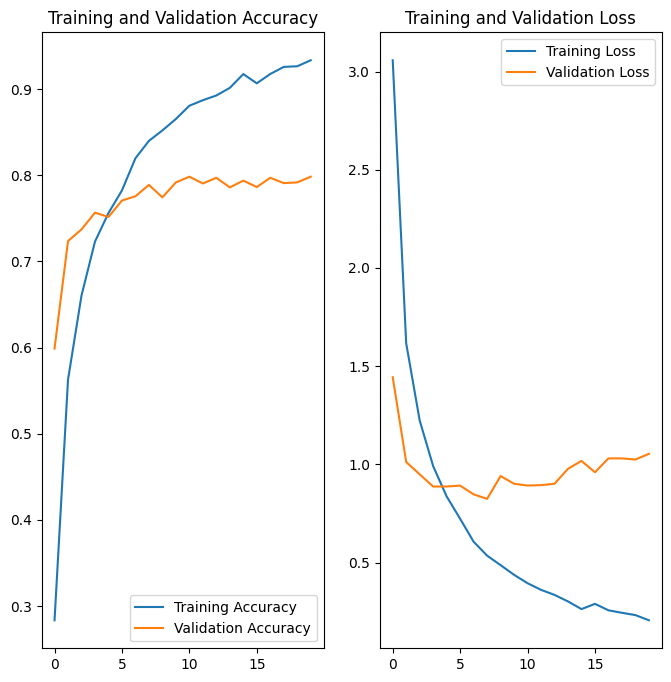

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epocas)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Matriz de Confusão

In [15]:
predictions = np.argmax(model.predict(test_images), axis=1)

cm = confusion_matrix(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions, target_names=test_images.class_indices, zero_division=0)

63/63 ━━━━━━━━━━━━━━━━━━━━ 47s 516ms/step


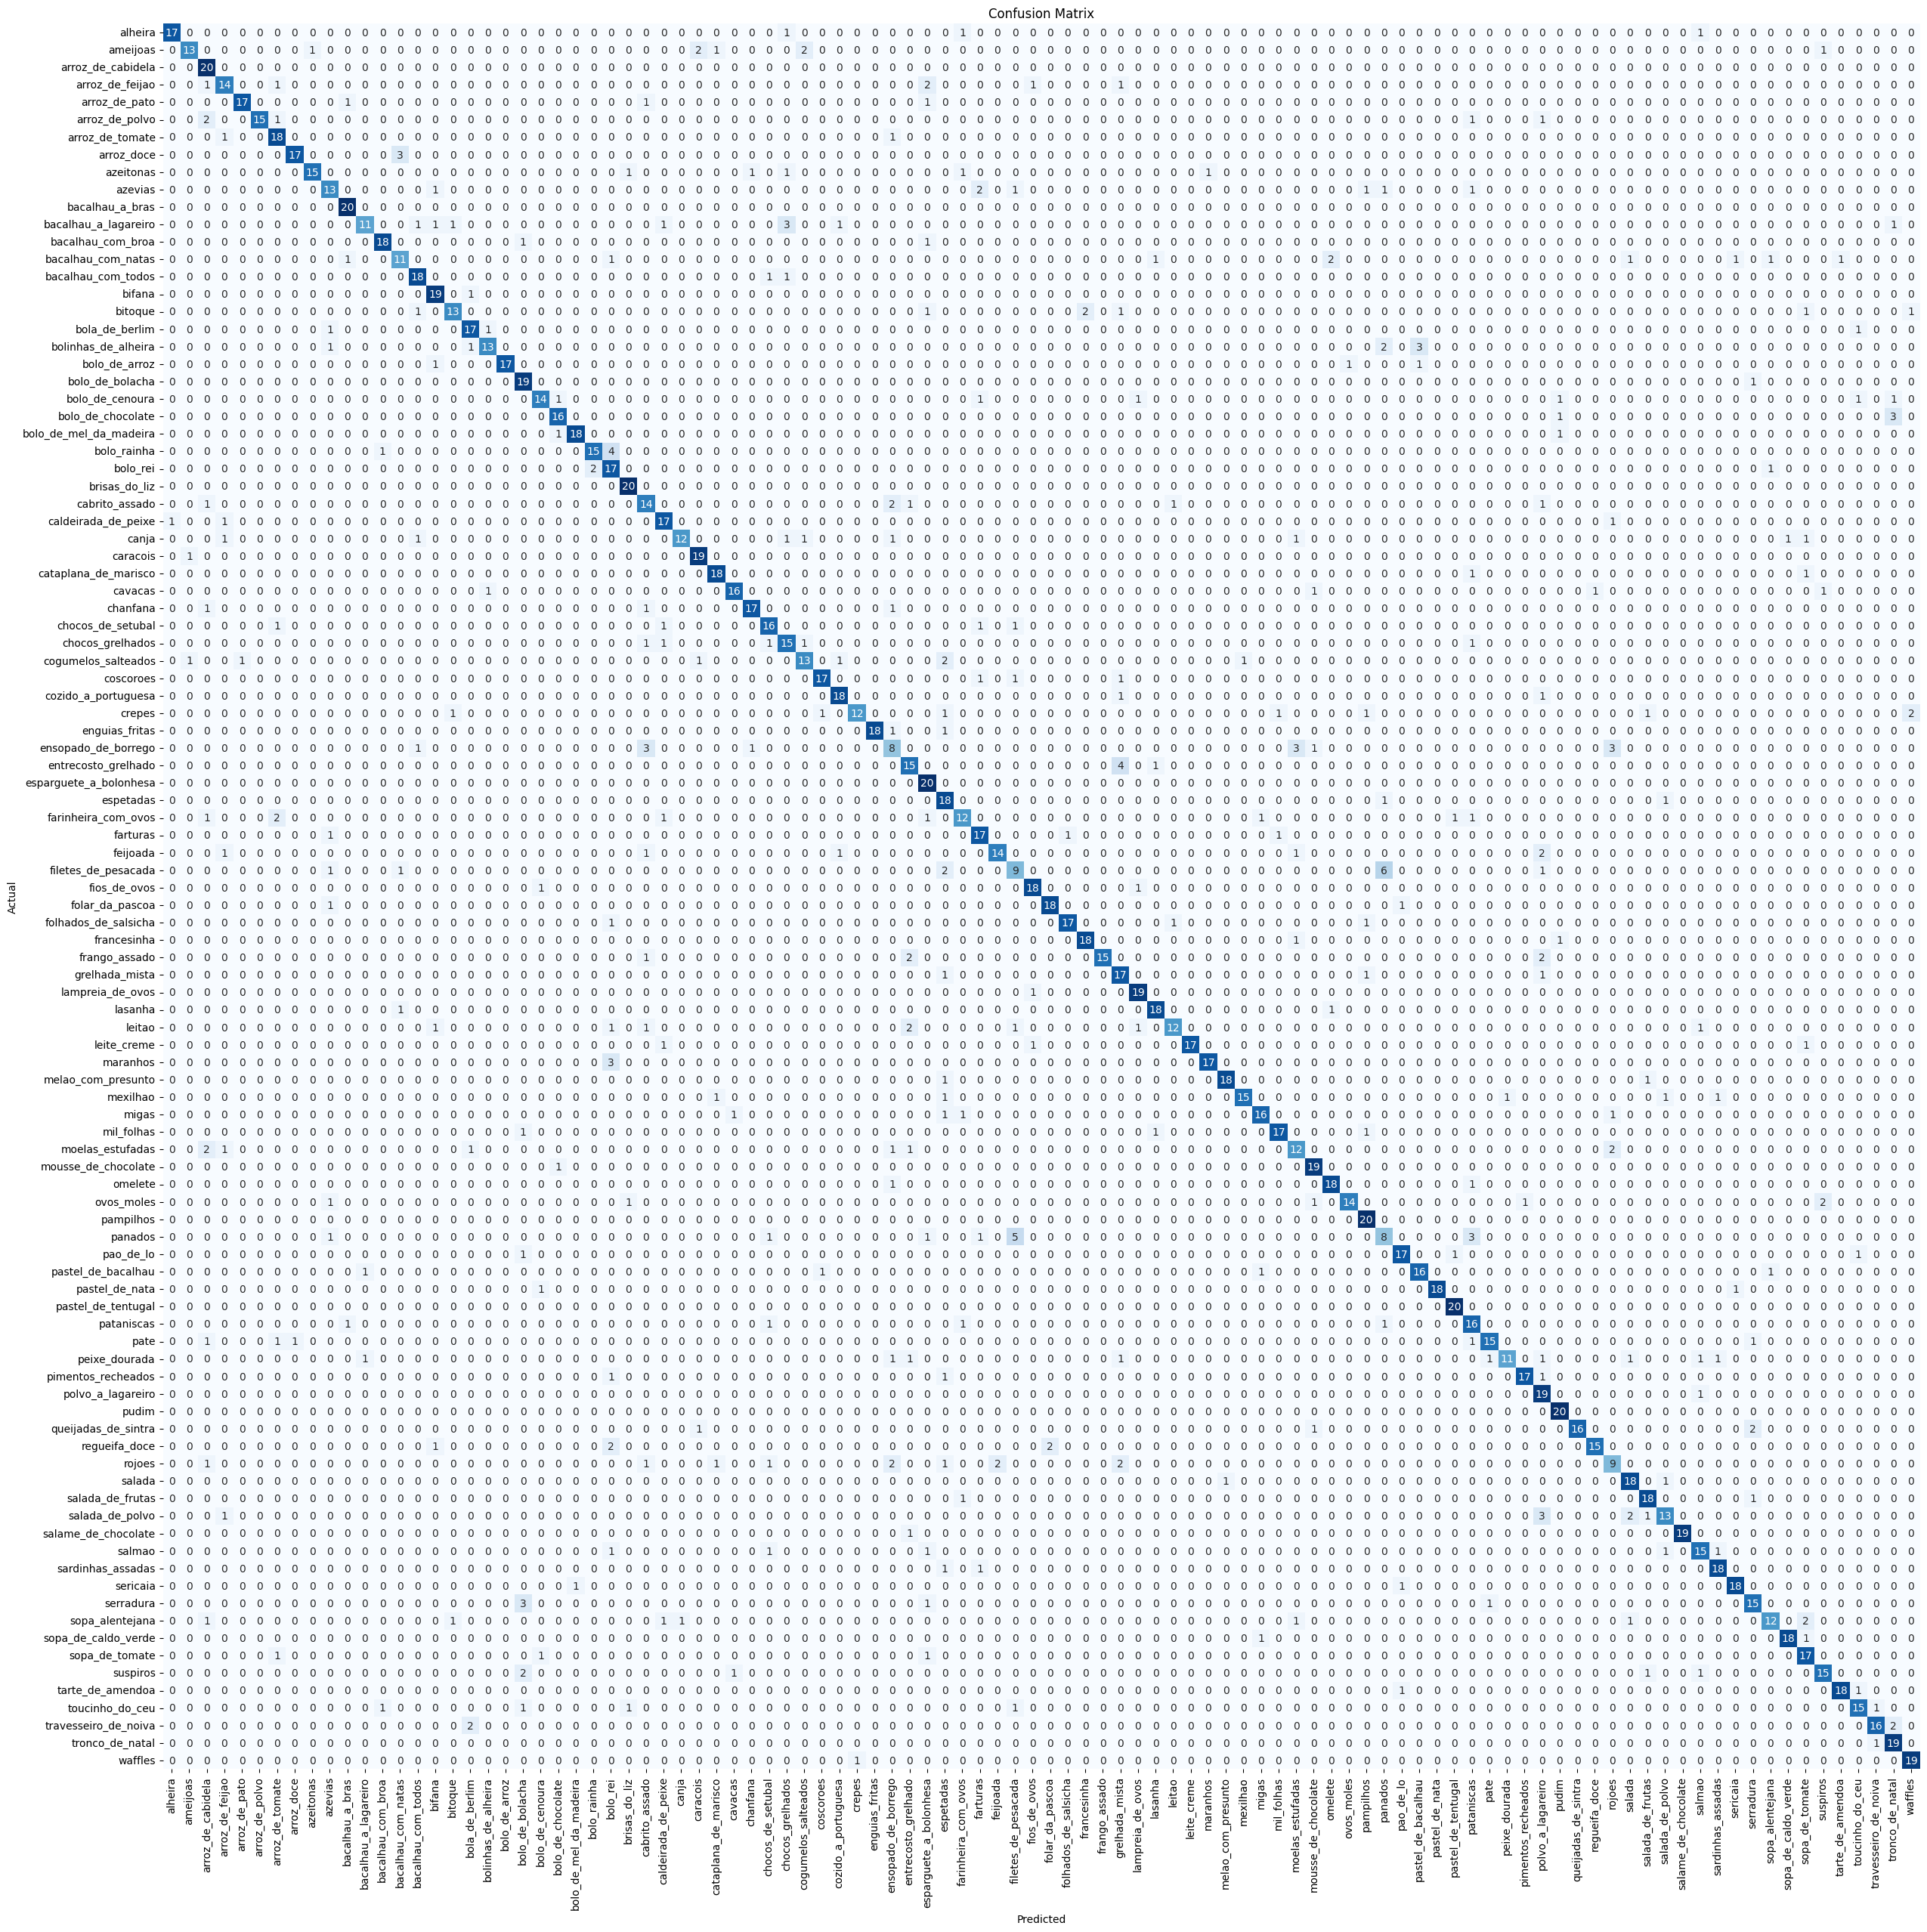

In [16]:
plt.figure(figsize=(30, 30))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(100) + 0.5, labels=test_images.class_indices, rotation=90)
plt.yticks(ticks=np.arange(100) + 0.5, labels=test_images.class_indices, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()